### MDSI Advanced Machine Learning Applications

Student: Ivan Cheung

Assignment: Kaggle 1


GitHub repo: https://github.com/ivanutsmdsi/amla2023

In [83]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, load_breast_cancer
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder   ## for normalising the feature data
from sklearn.model_selection import train_test_split              ## making test/train splits, for producing AUROC score?
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from joblib import dump
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import seaborn as sb

In [76]:
## Load raw data into dataframe
df = pd.read_csv('../data/raw/train.csv', low_memory=False)

In [9]:
## PREPROCESSING FUNCTIONS

## create a function to remove the corrupt columns and return a clean df
def remove_unwanted_cols(df):
    # ftr - no description given, removed from feature analysis
    # yr - player year details are descriptive, need to vectorise in future modelling
    # ht - player height data has been corrupted
    # num - payer number not relevant as a feature
    # pfr - no description given, removed from feature analysis
    # type - metadata field not relevant as a feature
    # year - no longitudinal inclusion for feature modeling

    df_clean = df.drop(["ht", "yr", "num", "type" ,"year", "ftr", "pfr"], axis = 1)    
    ##df_clean = df.drop(["team", "conf", "ht", "yr", "num", "type" ,"year", "ftr", "pfr"], axis = 1)

    return df_clean

## fill null values with 0
## TO IMPROVE: not all columns should be filled with 0. Will need to reveiw this moving forward...
def fillna(df):
    df_clean = df.fillna(0)

    return df_clean


In [41]:
## Create Standard Scalar and save to models
def scaler(df, num_cols):
    scaler = StandardScaler()
    features_df = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns = num_cols)
    dump(scaler, '../models/scaler.joblib')
    return features_df

## Create OHE and save to models
def OneHotEncode(df, cat_cols):
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    features = ohe.fit_transform(df[cat_cols])
    features_df = pd.DataFrame(features, columns=ohe.get_feature_names_out())

    dump(ohe, '../models/ohe.joblib')
    return features_df


In [77]:
## Preprocessing dataframe 

# remove unwanted columns, previously identified as corrupt
df_clean = remove_unwanted_cols(df)

# apply placeholder values for nulls
df_clean = fillna(df_clean)


In [78]:
## pop columns into separate lists
target = df_clean.pop('drafted')
player_ids = df_clean.pop('player_id')

In [79]:
## Apply Standard Scalar and OHE (for team name and conference name)
## define the numeric cols and the category cols from the df_clean dataset
num_cols = list(df_clean.select_dtypes('number').columns)
cat_cols = list(set(df_clean.columns) - set(num_cols))

# apply Scalar, save to placeholder
scaler_df = scaler(df_clean, num_cols)

# apply ohe, save to placeholder
ohe_df = OneHotEncode(df_clean, cat_cols)

# merge the two placeholder dfs together into one DF
df_clean = pd.concat([scaler_df, ohe_df], axis = 1)

# clean up placeholder variables from memory
del scaler_df
del ohe_df

In [ ]:
#numeric_transformer = Pipeline(steps= [("scaler", StandardScaler())])
#categorical_transformer = Pipeline(steps= [("encoder", StandardScaler())])

In [53]:
## ATTEMPT SMOTE

smote = SMOTE(random_state = 11) 
X_train, y_train = smote.fit_resample(df_clean, target)

In [60]:
## Showing results of the SMOTE, upsampling:
y_train.value_counts()

drafted
0.0    55555
1.0    55555
Name: count, dtype: int64

In [ ]:
# save processed files.
X_train.to_csv('../data/processed/X_train.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)

In [63]:
#Binary Classification: Logistic Regression model

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

dump(classifier, '../models/logistic_regression_2.joblib')

LogisticRegression(max_iter=1000)

### Testing the accuracy of prediction, against the training data

In [65]:
y_pred = classifier.predict(X_train)

In [68]:
cf_matrix = confusion_matrix(y_true=y_train, y_pred=y_pred)
cf_matrix

array([[54929,   626],
       [    0, 55555]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted label')

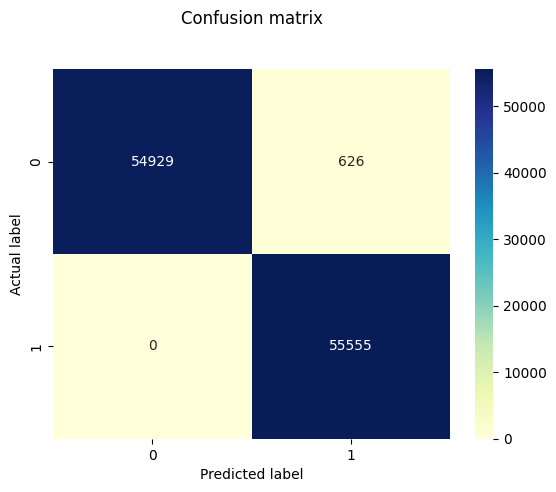

In [85]:
sb.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Testing the accuracy of prediction, against the test data

In [86]:
## Load raw data into dataframe
test_df = pd.read_csv('../data/raw/test.csv', low_memory=False)

## pop targets and player num
test_ids = test_df.pop('player_id')

## preprocessing steps
test_clean = remove_unwanted_cols(test_df)
test_clean = fillna(test_clean)

# data scaling and OHE
scaler_df = scaler(test_clean, num_cols)
ohe_df = OneHotEncode(test_clean, cat_cols)
test_clean = pd.concat([scaler_df, ohe_df], axis = 1)
del scaler_df
del ohe_df

In [87]:
test_pred = classifier.predict_proba(test_clean)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- team_Bellarmine
- team_Dixie St.
- team_Tarleton St.
- team_UC San Diego
Feature names seen at fit time, yet now missing:
- conf_GWC
- conf_Ind
- conf_Ivy
- conf_P10
- conf_ind
- ...
